### Installing Libraries & Prerequisites

In [ ]:
# 1.Environment Setup

import os
# Add imports as desired

# Install dependencies via requirements.txt instead of inline notebook commands
# !pip install -r requirements.txt



### Llama3 Models

In [ ]:
# 2.Model Download and Understanding

from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage.

fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",

    "unsloth/Llama-3.2-1B-bnb-4bit",
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit"
]
# Load selected model - chosen for balance of performance and Colab compatibility
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B", # Load model
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# Display detailed model architecture information
print(f"Number of layers: {model.config.num_hidden_layers}")
print(f"Vocabulary size: {model.config.vocab_size}") # number of tokens the model can handle

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.8: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Number of layers: 32
Vocabulary size: 128256


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
# 3. Model Fine-Tuning (Adding LoRA adapters)

# LoRA (Low-Rank Adaptation) configuration for efficient fine-tuning
model = FastLanguageModel.get_peft_model(
    model,
    r = 4,  # REDUCED from 8 - Lower rank = less overfitting
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 4,  # REDUCED from 8 - Lower alpha = more regularization
    lora_dropout = 0.4,  # INCREASED from 0.2 - Higher dropout = more regularization
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = True,  # CHANGED from False - Rank-stabilized LoRA
    loftq_config = None,
)

# Analyze parameter efficiency (addresses overfitting concerns)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print("=== PEFT Configuration Analysis ===")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Trainable percentage: {100 * trainable_params / total_params:.2f}%")


Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.4.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.6.8 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


=== PEFT Configuration Analysis ===
Total parameters: 4,639,166,464
Trainable parameters: 10,485,760
Trainable percentage: 0.23%


<a name="Data"></a>
### Data Prep
We now use the `Llama-3.1` format for conversation style finetunes. We use [Maxime Labonne's FineTome-100k](https://huggingface.co/datasets/mlabonne/FineTome-100k) **as an example only** dataset in ShareGPT style. But we convert it to HuggingFace's normal multiturn format `("role", "content")` instead of `("from", "value")`/ Llama-3 renders multi turn conversations like below:

```
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Hello!<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Hey there! How are you?<|eot_id|><|start_header_id|>user<|end_header_id|>

I'm great thanks!<|eot_id|>
```

We use our `get_chat_template` function to get the correct chat template.  Supports `zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, phi3, llama3` and more.

In [ ]:
# 4. Dataset Preparation (Loading, cleaning, splitting, formatting) - FIXED VERSION

from unsloth.chat_templates import get_chat_template
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset
import pandas as pd

# Configure tokenizer with appropriate chat template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",  # Match the model version
)

# Load and analyze dataset (project requirement: proper selection)
dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT", "en",split='train')
print("=== Dataset Analysis ===")
print(f"Dataset: AI medical chatbot (English, small size as required)")
print(f"Total samples: {len(dataset)}")
print(f"Features: {dataset.features}")
print(f"Column names: {dataset.column_names}")
print("\nSample entry:")
print(f"Question: {dataset[0]['Question'][:100]}...")
print(f"Response: {dataset[0]['Response'][:100]}...")

# Data preprocessing and formatting function
def formatting_prompts_func(examples):
    """
    Format examples into chat template format with data cleaning
    Must return same number of items as input for batched processing
    """
    prompts = []
    # Handle both single examples and batched examples
    questions = examples["Question"] if isinstance(examples["Question"], list) else [examples["Question"]]
    answers = examples["Response"] if isinstance(examples["Response"], list) else [examples["Response"]]

    for q, a in zip(questions, answers):
        # Data cleaning
        q = str(q).strip() if q else ""
        a = str(a).strip() if a else ""

        # Handle empty or invalid entries by creating placeholder or basic format
        if not q or not a or len(q) < 5 or len(a) < 5:
            # Create a basic valid entry instead of skipping
            q = q if q else "What is a basic health tip?"
            a = a if a else "Stay hydrated and get enough rest."

        # Format using model's chat template
        text = f"<|start_header_id|>user<|end_header_id|>\n\n{q}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n{a}<|eot_id|>"
        prompts.append(text)

    return {"text": prompts}

# Enhanced data cleaning function
def clean_dataset(dataset):
    """Clean dataset before splitting"""
    print("\n=== Data Cleaning ===")

    # Convert to pandas for easier filtering
    df = dataset.to_pandas()
    initial_count = len(df)

    # Clean and filter dataset
    df = df.dropna(subset=['Question', 'Response'])
    df = df[df['Question'].str.len() >= 10]  # Remove very short questions
    df = df[df['Response'].str.len() >= 10]   # Remove very short answers
    df = df[df['Question'].str.len() <= 500]  # Remove overly long questions
    df = df[df['Response'].str.len() <= 1000]   # Remove overly long answers
    df = df.drop_duplicates(subset=['Question'])  # Remove duplicate questions

    # IMPORTANT: Reset index and drop the old index to avoid conflicts
    df = df.reset_index(drop=True)

    print(f"After cleaning: {len(df)} samples (removed {initial_count - len(df)})")
    return df

# Clean the dataset first
cleaned_df = clean_dataset(dataset)

# Dataset splitting (project requirement: train/validation/test)
train_df, temp_df = train_test_split(cleaned_df, test_size=0.3, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

print(f"\n=== Data Split Results ===")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Convert back to datasets format - FIX: Remove index columns and reset
try:
    # Method 1: Create datasets directly from the relevant columns only
    train_ds = Dataset.from_dict({
        'Question': train_df['Question'].tolist(),
        'Response': train_df['Response'].tolist()
    })
    val_ds = Dataset.from_dict({
        'Question': val_df['Question'].tolist(),
        'Response': val_df['Response'].tolist()
    })
    test_ds = Dataset.from_dict({
        'Question': test_df['Question'].tolist(),
        'Response': test_df['Response'].tolist()
    })

    print("✅ Successfully created datasets using from_dict method")

except Exception as e:
    print(f"❌ Method 1 failed: {e}")
    print("Trying alternative method...")

    # Method 2: Clean up index columns before conversion
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    # Remove any columns that start with __index
    for col in train_df.columns:
        if col.startswith('__index'):
            train_df = train_df.drop(columns=[col])
            val_df = val_df.drop(columns=[col])
            test_df = test_df.drop(columns=[col])

    train_ds = Dataset.from_pandas(train_df, preserve_index=False)
    val_ds = Dataset.from_pandas(val_df, preserve_index=False)
    test_ds = Dataset.from_pandas(test_df, preserve_index=False)

    print("✅ Successfully created datasets using from_pandas method")

# Apply formatting to all splits
print("\n=== Applying Chat Template Formatting ===")
train_ds = train_ds.map(formatting_prompts_func, batched=True, remove_columns=train_ds.column_names)
val_ds = val_ds.map(formatting_prompts_func, batched=True, remove_columns=val_ds.column_names)
test_ds = test_ds.map(formatting_prompts_func, batched=True, remove_columns=test_ds.column_names)

print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")

print("\n=== Formatted Sample ===")
print("Sample formatted text:")
print(train_ds[0]['text'][:400] + "...")

# Verify data quality
print(f"\n=== Data Quality Check ===")
sample_lengths = [len(train_ds[i]['text']) for i in range(min(5, len(train_ds)))]
print(f"Sample text lengths: {sample_lengths}")
print("✅ Data preprocessing complete!")

=== Dataset Analysis ===
Dataset: AI medical chatbot (English, small size as required)
Total samples: 19704
Features: {'Question': Value(dtype='string', id=None), 'Complex_CoT': Value(dtype='string', id=None), 'Response': Value(dtype='string', id=None)}
Column names: ['Question', 'Complex_CoT', 'Response']

Sample entry:
Question: Given the symptoms of sudden weakness in the left arm and leg, recent long-distance travel, and the ...
Response: The specific cardiac abnormality most likely to be found in this scenario is a patent foramen ovale ...

=== Data Cleaning ===
After cleaning: 15523 samples (removed 4181)

=== Data Split Results ===
Training samples: 10866
Validation samples: 2328
Test samples: 2329
✅ Successfully created datasets using from_dict method

=== Applying Chat Template Formatting ===


Map:   0%|          | 0/10866 [00:00<?, ? examples/s]

Map:   0%|          | 0/2328 [00:00<?, ? examples/s]

Map:   0%|          | 0/2329 [00:00<?, ? examples/s]

Training samples: 10866
Validation samples: 2328
Test samples: 2329

=== Formatted Sample ===
Sample formatted text:
<|start_header_id|>user<|end_header_id|>

What is the most likely diagnosis for a 9-month-old infant who had a high fever followed by a generalized, nonpruritic maculopapular rash that blanches on pressure, starting from the trunk and spreading to the extremities, with posterior auricular lymphadenopathy and no current fever?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The most likely ...

=== Data Quality Check ===
Sample text lengths: [1013, 1010, 1177, 914, 997]
✅ Data preprocessing complete!


We now use `standardize_sharegpt` to convert ShareGPT style datasets into HuggingFace's generic format. This changes the dataset from looking like:
```
{"from": "system", "value": "You are an assistant"}
{"from": "human", "value": "What is 2+2?"}
{"from": "gpt", "value": "It's 4."}
```
to
```
{"role": "system", "content": "You are an assistant"}
{"role": "user", "content": "What is 2+2?"}
{"role": "assistant", "content": "It's 4."}
```

In [ ]:
# 5. Dataset Preparation (Standardizing ShareGPT format)
from unsloth.chat_templates import standardize_sharegpt
# dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/19704 [00:00<?, ? examples/s]

We look at how the conversations are structured for item 5:

In [ ]:
dataset[5]["Question"]

'A patient with psoriasis was treated with systemic steroids, and upon discontinuation of the treatment, developed generalized pustules all over the body. What is the most likely cause of this condition?'

In [ ]:
dataset[5]["Response"]

'The development of generalized pustules in a patient with psoriasis following the discontinuation of systemic steroid treatment is most likely due to a condition called generalized pustular psoriasis (GPP). This condition can occur as a rebound effect when systemic steroids are suddenly stopped or rapidly tapered down. In patients with psoriasis, steroids can suppress the immune system and mitigate symptoms. When these drugs are withdrawn too quickly, the immune system can overreact, leading to more severe symptoms, including the transformation of psoriasis into a pustular form. Careful management and slow tapering of steroids are critical in psoriasis patients to prevent such exacerbations.'

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [ ]:
  from trl import SFTTrainer
  from transformers import TrainingArguments, DataCollatorForSeq2Seq, EarlyStoppingCallback
  from unsloth import is_bfloat16_supported

  trainer = SFTTrainer(
      model = model,
      tokenizer = tokenizer,
      train_dataset = train_ds,  # Changed: Use training split instead of entire dataset
      eval_dataset = val_ds,
      dataset_text_field = "text",
      max_seq_length = max_seq_length,
      data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
      dataset_num_proc = 2,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
      packing = False, # Can make training 5x faster for short sequences.
      args = TrainingArguments(
          per_device_train_batch_size = 8,
          gradient_accumulation_steps = 4,
          warmup_steps = 10,
          eval_strategy="steps",            # run val every eval_steps
          eval_steps=50,                          # choose a smaller interval
          # save_steps= 50,
          # save_total_limit = 2,
          logging_steps=50,
          load_best_model_at_end = True,
          metric_for_best_model="eval_loss",
          greater_is_better=False,  #

          # num_train_epochs = 1, # Set this for 1 full training run.
          max_steps = 400, # Choose max-steps
          learning_rate = 2e-5, # 2e-4 did good, can you do better?
          fp16 = not is_bfloat16_supported(),
          bf16 = is_bfloat16_supported(),
          optim = "adamw_8bit",
          weight_decay = 0.01,
          lr_scheduler_type = "cosine_with_restarts", # change back to linear
          seed = 3407,
          output_dir = "outputs",
          report_to = "none", # Use this for WandB etc
      ),
  )

Unsloth: Tokenizing ["text"]:   0%|          | 0/10866 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"]:   0%|          | 0/2328 [00:00<?, ? examples/s]

We also use Unsloth's `train_on_completions` method to only train on the assistant outputs and ignore the loss on the user's inputs.

In [ ]:
# 8. Model Fine-Tuning (Training on responses only)
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map (num_proc=2):   0%|          | 0/10866 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/2328 [00:00<?, ? examples/s]

Verify masking is actually done:

In [ ]:
# 9: Model Fine-Tuning (Verify masking)

tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\nAt what specific value of a one-hour glucose challenge test will you recommend conducting a standard glucose tolerance test?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nIf a one-hour glucose challenge test result is 140 mg/dL or higher, it is recommended to conduct a standard glucose tolerance test for further evaluation. This threshold is consistent with most guidelines for identifying individuals who may be at risk for gestational diabetes and require additional testing.<|eot_id|>'

In [ ]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

'                               If a one-hour glucose challenge test result is 140 mg/dL or higher, it is recommended to conduct a standard glucose tolerance test for further evaluation. This threshold is consistent with most guidelines for identifying individuals who may be at risk for gestational diabetes and require additional testing.<|eot_id|>'

We can see the System and Instruction prompts are successfully masked!

In [ ]:
# 11: Environment Setup (Show memory stats before training)

# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
7.135 GB of memory reserved.


In [ ]:

655# 12: Model Fine-Tuning (Execute training)
from unsloth import unsloth_train
trainer_stats = unsloth_train(trainer)


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 10,866 | Num Epochs = 2 | Total steps = 400
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 4 x 1) = 32
 "-____-"     Trainable parameters = 10,485,760/8,000,000,000 (0.13% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
50,1.338600,1.157632
100,1.110400,1.085932
150,1.079900,1.060635
200,1.048600,1.049232
250,1.037300,1.042540
300,1.041600,1.038996
350,1.066700,1.037662
400,1.033100,1.037430


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [ ]:
# 13: Environment Setup (Show final memory stats), Model Evaluation (Report final training loss)

# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")
print(f"Final training loss: {trainer_stats.metrics.get('train_loss', 'N/A')}")

13197.1394 seconds used for training.
219.95 minutes used for training.
Peak reserved memory = 7.721 GB.
Peak reserved memory for training = 0.586 GB.
Peak reserved memory % of max memory = 52.378 %.
Peak reserved memory for training % of max memory = 3.975 %.
Final training loss: 1.0945029067993164


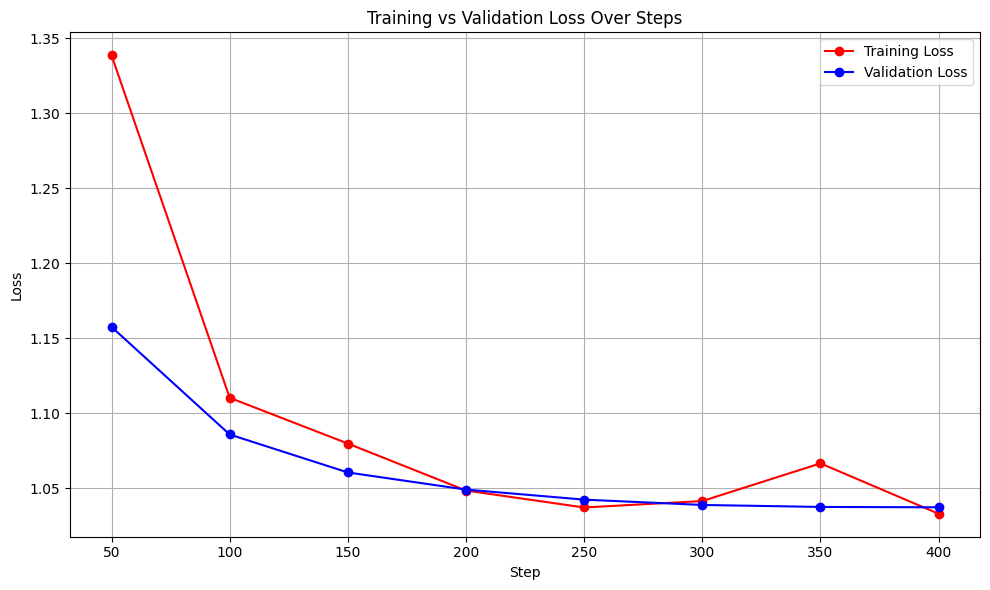

In [ ]:
# 14: Model Evaluation (Visualize loss)

import matplotlib.pyplot as plt
import seaborn as sns

training_logs = trainer.state.log_history

# training_logs = trainer_stats.metrics['train_loss']


# Extract training loss with corresponding steps
train_logs = [log for log in training_logs if 'loss' in log]
train_losses = [log['loss'] for log in train_logs]
train_steps = [log['step'] for log in train_logs]

eval_logs = [log for log in training_logs if 'eval_loss' in log]
eval_losses = [log['eval_loss'] for log in eval_logs]
eval_steps = [log['step'] for log in eval_logs]

# Plot with correct step alignment
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Training Loss', color='red', marker='o')
plt.plot(eval_steps, eval_losses, label='Validation Loss', color='blue', marker='o')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss Over Steps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# # 15: Model Evaluation (Test on test set)

# FastLanguageModel.for_inference(model)

# print("=== Testing on Test Set ===")
# for i in range(min(3, len(test_ds))):
#     test_question = test_ds[i]['text'].split('<|start_header_id|>user<|end_header_id|>')[1].split('<|start_header_id|>assistant<|end_header_id|>')[0].strip()

#     messages = [{"role": "user", "content": test_question}]
#     inputs = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

#     outputs = model.generate(input_ids=inputs, max_new_tokens=100, use_cache=True, temperature=0.7)
#     prediction = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)

#     print(f"\nTest {i+1}:")
#     print(f"Q: {test_question[:80]}...")
#     print(f"A: {prediction[:80]}...")

In [ ]:
# 16: Model Evaluation (Example inference)

from unsloth.chat_templates import get_chat_template
from transformers import GenerationConfig

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages_firstaid = [
    {"role": "user", "content": "What should I do if someone is choking?"},
]
inputs = tokenizer.apply_chat_template(
    messages_firstaid,
    tokenize = True,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")

attention_mask = torch.ones_like(inputs, device="cuda")
generation_config = GenerationConfig(
    max_new_tokens=64,
    temperature=0.8,
    top_p=0.9,
    pad_token_id=tokenizer.eos_token_id,
)

outputs = model.generate(
    input_ids=inputs,
    attention_mask=attention_mask,
    generation_config=generation_config,
    use_cache=True,
)
decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
safety_prefix = "This model is not a medical professional. In emergencies, call local emergency services."
[f"{safety_prefix}

{decoded}"]


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
# 17: Optimization and Model Saving (Save LoRA adapters locally)

model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
# 18: Optimization and Model Saving (Load LoRA adapters - for testing)

if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "medicine for headaches"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Ibuprofen is commonly recommended for treating headaches. This medication can help with headaches related to inflammation or muscle tension, and is often preferred because it's safe and widely available over the counter. If headaches continue or become more severe, seeking medical advice is advisable for appropriate diagnosis and management. It's also good practice to take Ibuprofen according to the dosage and frequency guidelines provided on the packaging for safety.>
<|begin_of_text|>:// kurtul eoqkrvldkfภาคมofday: 26 July 2024تیجه

되었습니다/ayushmanZeroWidthSpace<|begin_of_text|>://ldkf<|begin_of_text|>://ldkf:ldkf:aload://ldkfџџџldkfџџџџldkf>
ldkfџџџџџџџџldkfyalty料無料labilirlabilirldkfyalty<|begin_of_text|>://


### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

### Login Huggingface using Token ###

In [ ]:
#  19: Optimization and Model Saving (Login to Hugging Face Hub)

from huggingface_hub import login

login(token="INSERT TOKEN")

### Create Model Huggingface Repository ###

In [ ]:
# 20: Optimization and Model Saving (Create Hugging Face repository)

from huggingface_hub import create_repo

# Replace "your-username" with your actual HF username
repo_name = "Your Repository"

# Create the repository
create_repo(repo_name, exist_ok=True, private=False)
print(f"Repository created: https://huggingface.co/{repo_name}")

model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

Repository created: https://huggingface.co/DarkVader23949/medical_llama_new


NameError: name 'model' is not defined

Choose your desired gguf format, I recommend using Q4_K_M as it's the most capable and runs okay locally.

In [ ]:
# Optimization and Model Saving (Save/Push GGUF in q4_k_m)

# Save to q4_k_m GGUF
model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
model.push_to_hub_gguf("DarkVader23949/medical_llama_new", tokenizer, quantization_method = "q4_k_m", token = "INSERT TOKEN")


if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )


Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which might take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 6.0G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 2.2 out of 12.67 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


 47%|████▋     | 15/32 [00:01<00:01, 13.57it/s]
We will save to Disk and not RAM now.
100%|██████████| 32/32 [07:41<00:00, 14.42s/it]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model/pytorch_model-00001-of-00004.bin...
Unsloth: Saving model/pytorch_model-00002-of-00004.bin...


If Q4_K_M is too heavy, you can use other formats, choose from those:

In [ ]:
# 21: Optimization and Model Saving (Save/Push GGUF in different quantizations)

# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("DarkVader23949/first_aid_lama", tokenizer, token = "INSERT TOKIN")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")


